## Embedded Faults (interface2d): overview


In the context of a 2D continuum flow model, an embedded fault is a 1d line (based on on an Underworld2 swarm object) that we advect with the flow, and can be used to maintain and constrain a finite region of distinct material properties.


For further details about the embedded fault approach see:

_Sandiford, Dan, and Louis Moresi. "Improving subduction interface implementation in dynamic numerical models." Solid Earth 10.3 (2019): 969-985_

Note that the nomenclature in the paper diverges somewhat from the code.  The python object that encapsualtes the 'embedded fault' approach is named `interface2D` ( `UWsubduction.interfaces.interface2D.interface2D`)




This notebook demonstrates:


* Setting up embedded faults (interface2D objects)
* setting proximity and orientation on global swarm
* orientation of embedded faults 


In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator
import UWsubduction as usub

In [24]:
#Set up a box to play with

minX = -1.0
maxX = 1.0
resX = 12
resY = 6
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, -0.5), 
                                 maxCoord    = ( maxX, 0.5),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [25]:
coordinate = fn.input()
yFn = coordinate[1]
xFn= coordinate[0]

In [26]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [27]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable   = swarm.add_variable( dataType="double", count=1)
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [126]:
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

markerXs = np.linspace(-1.2, 1.2, 40)
markerYs = np.linspace(-0.6, 0.6, 40)


markerThickness = 0.125


#set up two embedded fault objects

ef1 = usub.interface2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))
ef2 = usub.interface2D(mesh, velocityField, markerXs, -1.*markerYs, 
                        markerThickness, 2, insidePt=(0.,-10.))


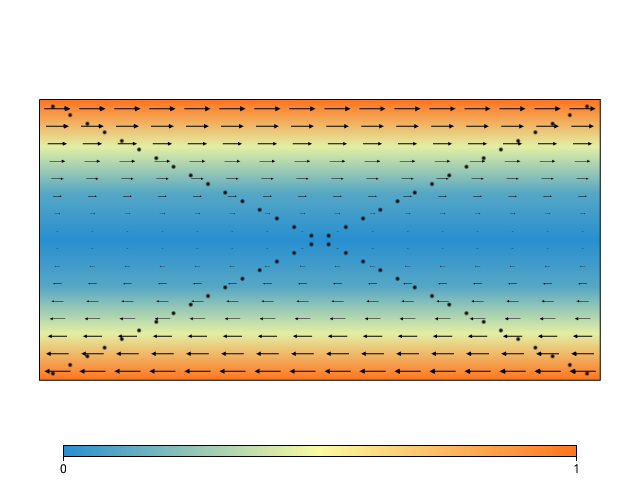

In [127]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
fig1.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)) )
fig1.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))
fig1.append( glucifer.objects.Points(ef2.swarm, pointsize = 5))

fig1.show()

## Mapping the embedded fault to the material swarm (proximity)

In [128]:
#proximity

In [129]:
#utilise some methods of the efs to set the proximityVariable

#return an array of the signed distance of each material swarm particle
#relative to the embedded fault
#The sign is determined using the insidePt the interface2D
#fpts is an array (size of material swarm)  with id of the nearest particle in the embedded fault

sd, fpts = ef2.compute_signed_distance(swarm.particleCoordinates.data, distance = 1e3)


#make a dummy function tp dictate variable thickness
thicknessfn  = markerThickness*fn.math.cos(np.pi*xFn) + markerThickness
dat = thicknessfn.evaluate(swarm)

#set the proximity variable where the signed distance is positive and less than the value of thicknessFn
mask = np.logical_and(sd < dat,sd > 0)
signedDistanceVariable.data[:] = sd
proximityVariable.data[mask] = ef2.ID




In [130]:
#For the other embedded fault, we'll do the same but with a more direct approach using `set_proximity_director`
#Note that `minDistanceFn`, etc, are provided as  a dimensionless fraction relative to the ed.faultThickness

thicknessFractionFn = thicknessfn/markerThickness

ef1.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=.0,
                                    minDistanceFn=thicknessFractionFn,
                                    maxDistanceFn=thicknessFractionFn)
        


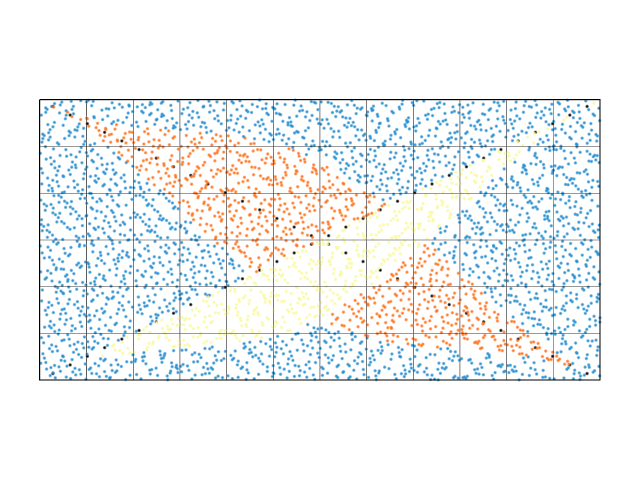

In [131]:
fig2 = glucifer.Figure(quality=2)
fig2.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 4, colourBar=False, quality=2))
fig2.append(glucifer.objects.Mesh(mesh, opacity= 0.4))

fig2.append( glucifer.objects.Points(ef1.swarm, pointsize = 4,marker =5, quality=2))
fig2.append( glucifer.objects.Points(ef2.swarm, pointsize = 4,marker =5, quality=2))


fig2.show()

## The director variable

In [132]:
# The embedded fault also stores an orthogonal vector accessed by ef.dirctor
# We can also propagate this information to a variable on the material swarm,
# Which will then know its orientation relative to the embedded fault

ef1.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=.0,
                                    minDistanceFn=thicknessFractionFn,
                                    maxDistanceFn=thicknessFractionFn, 
                                    directorVar=directorVariable)


ef2.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=.0,
                                    minDistanceFn=thicknessFractionFn,
                                    maxDistanceFn=thicknessFractionFn, 
                                    directorVar=directorVariable)



Populating the interactive namespace from numpy and matplotlib


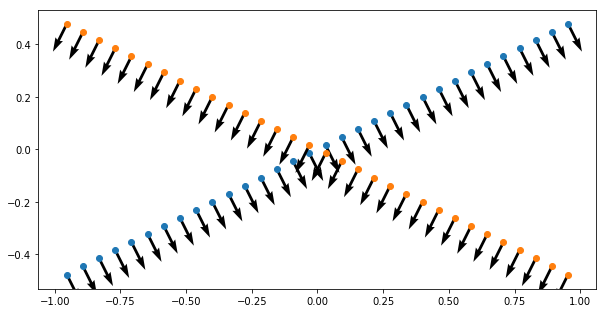

In [133]:
%pylab inline



fig, ax = plt.subplots(figsize=(10.,10))

Q = ax.quiver(ef1.swarm.data[:,0], ef1.swarm.data[:,1], 
               ef1.director.data[:,0], ef1.director.data[:,1], units='width', width = 0.005)

ax.scatter(ef1.swarm.data[:,0], ef1.swarm.data[:,1])


Q2 = ax.quiver(ef2.swarm.data[:,0], ef2.swarm.data[:,1], 
               ef2.director.data[:,0], ef2.director.data[:,1], units='width', width = 0.005)

ax.scatter(ef2.swarm.data[:,0], ef2.swarm.data[:,1])



#ax.scatter(1.05*testPs[:,0], 1.05*testPs[:,1],  s = 1)

ax.set_aspect('equal')

## Relative strain rate components

One use case for the director functionality is decomposing the strainrate into components normal and parallel to the embedded fault. 

This could be used either for vizualisation purposes, or to define an anisotropic rheology ( The underworld Stokes system has arguments for a director (orientation) and second viscosity), allowing a transversly isostropic rhological model. 

Here we show how the relative strain rate components can be determined

In [14]:
#first we create a collection of the embedded faults
ef_coll = usub.interface_collection([ef1, ef2])

#deternmine the strain rate components normal and pararallel 
edotn, edots = ef_coll.global_line_strainrate_fns( velocityField, directorVariable, proximityVariable)


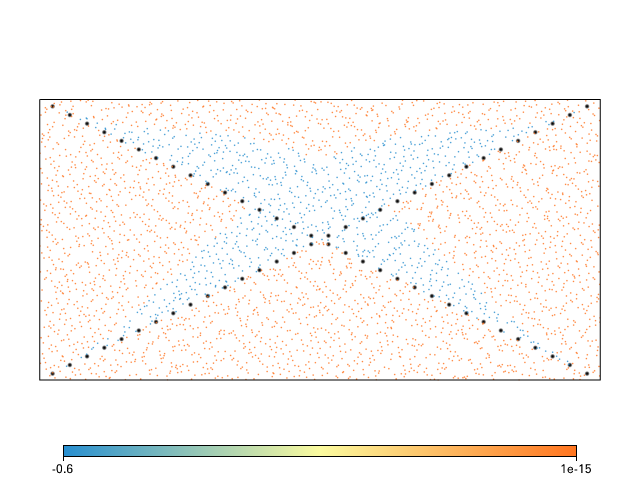

In [15]:
#

fig4 = glucifer.Figure()

#fig4.append( glucifer.objects.Points(swarm, fn.math.sqrt(edots**2 + edotn**2), pointsize = 2))
fig4.append( glucifer.objects.Points(swarm, edots, pointsize = 2))


fig4.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))
fig4.append( glucifer.objects.Points(ef2.swarm, pointsize = 5))
fig4.show()

## A more complicated geometry

So far the sign convection for the orientation of the embedded fault is based on the `InsidePt` variable we pass to the constructor.

For more complicated geometries, this may not be sufficient. We can instead use another Interface2D object to define the orientation. Instead of using a single `InsidePt`, the sign of the orientation is now defined using teh nearest neighbour in the second Interface2D object. 

Note the director always points in the direction orthogonal to a given Interface2D object. The InsidePt only determines the sign of the orientation.

The director vector will point towards the `InsidePt`.



In [100]:
#spiral points

def polar_to_cartesian(r, theta):
    return r*np.cos(theta), r*np.sin(theta)


def spiral(N, thetastart, dtheta, rstart, rend):
    points = []
    rs = np.linspace(rstart, rend, N)
    rnorm = rs.mean()
    theta= thetastart
    sp = polar_to_cartesian(rstart, theta)
    points.append(sp)
    for i in range(1, N):
        sp = polar_to_cartesian(rs[i], theta)
        points.append(sp)
        theta += dtheta/(rs[i]/rnorm)
        
    return np.array(points)
        
     

In [135]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [136]:
coordinate = fn.input()
yFn = coordinate[1]

In [137]:
spiralEf = usub.interface2D(mesh, velocityField, [], [],
                        0.1, 1, insidePt=(0., -10.))
                        
referenceEf = usub.interface2D(mesh, velocityField, [], [],
                        0.1, 2, insidePt=(0.,-10.))

In [138]:
spiralPoints = spiral(50, 0, np.deg2rad(5.5), 0.05, 0.8)[1:, ]
referencePoints = spiralPoints*0.95

#Add points
spiralEf.add_points(spiralPoints[:,0], spiralPoints[:,1])
referenceEf.add_points(referencePoints[:,0], referencePoints[:,1])


#now assign the refline as the insidePt for the line
spiralEf.insidePt = referenceEf


print(isinstance(spiralEf.insidePt, usub.interface2D))

spiralEf.rebuild()
spiralEf._update_surface_normals()

True


In [139]:
#spiral(50, 0, np.deg2rad(5.5), 0.05, 0.8)


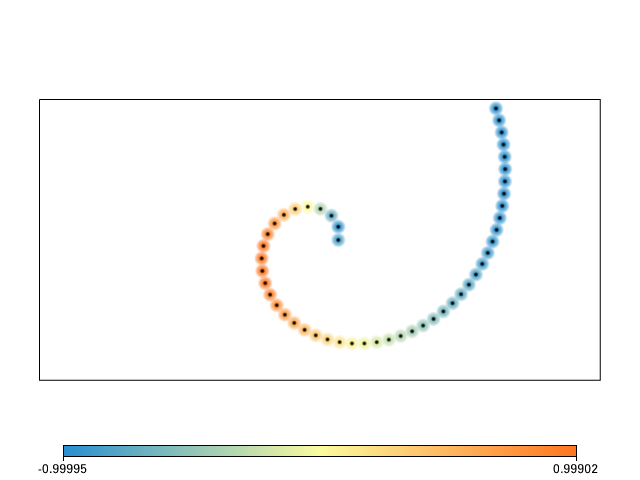

In [140]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.Surface(mesh, 0., colours = 'red white yellow', colourBar=False)) 
fig2.append( glucifer.objects.Points(spiralEf.swarm, pointsize = 5))
fig2.append( glucifer.objects.Points(spiralEf.swarm, spiralEf.director[0], pointsize = 15))

fig2.show()


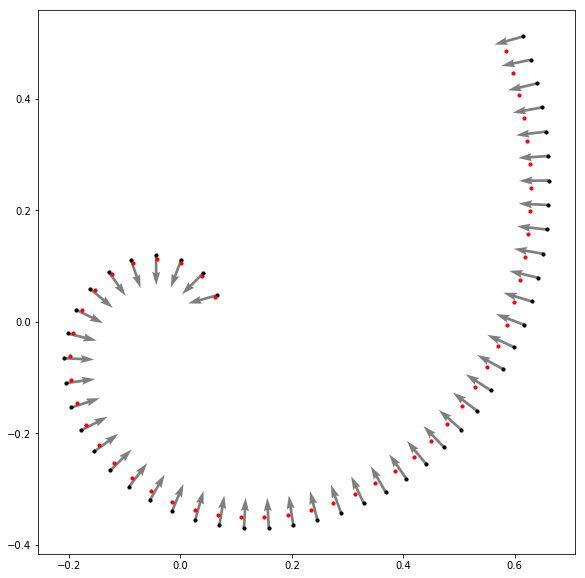

In [144]:

fig, ax = plt.subplots(figsize=(10.,10))

Q = ax.quiver(spiralPoints[1:,0], spiralPoints[1:,1], 
               spiralEf.director.data[1:,0], spiralEf.director.data[1:,1], 
              units='width', width = 0.005, alpha = 0.5)

ax.scatter(spiralPoints[1:,0], spiralPoints[1:,1], s=10, c = 'k')
ax.scatter(referencePoints[1:,0], referencePoints[1:,1],  s = 10, c = 'r')

ax.set_aspect('equal')